# Neutrophil Atlas DA Peaks

**Created**: 18 March 2022

In [57]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

if (!requireNamespace("umap")) {
    install.packages("umap")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

In [58]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)
library(limma)
library(umap)
library(UpSetR)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

## Load Data

In [73]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Lineage, Cell_type, Stimulated, Treatment) %>%
    dplyr::filter(grepl("Ram-Mohan", Donor)) %>%
    unique() %>%
    dplyr::mutate(Treatment = gsub("-", "", Treatment)) %>%
    dplyr::mutate(Donor = gsub("-", "", Donor)) %>%
    dplyr::arrange(Lineage, Cell_type, Treatment, Donor)

rownames(sample.info) <- sample.info$Group.ID

In [74]:
head(sample.info)

,Group.ID,Donor,Lineage,Cell_type,Stimulated,Treatment
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-BGP,RamMohanD1,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,RamMohanD2,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,RamMohanD3,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,RamMohanD4,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D1-Neutrophils-Control,Ram-Mohan-D1-Neutrophils-Control,RamMohanD1,MYELOID,Neutrophils,FALSE,Control
Ram-Mohan-D2-Neutrophils-Control,Ram-Mohan-D2-Neutrophils-Control,RamMohanD2,MYELOID,Neutrophils,FALSE,Control


In [75]:
peak.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) { x[1] })

peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(sample.info$Group.ID))

In [76]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-Control,⋯,Ram-Mohan-D1-Neutrophils-R848,Ram-Mohan-D2-Neutrophils-R848,Ram-Mohan-D3-Neutrophils-R848,Ram-Mohan-D4-Neutrophils-R848,Ram-Mohan-D1-Neutrophils-SA-1,Ram-Mohan-D1-Neutrophils-SA-3,Ram-Mohan-D2-Neutrophils-SA-3,Ram-Mohan-D1-Neutrophils-SA-5,Ram-Mohan-D1-Neutrophils-WB,Ram-Mohan-D2-Neutrophils-WB
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:10002-10772,1,10002,10772,+,48,120,149,91,184,⋯,88,162,255,247,861,706,327,659,711,367
1:11009-11428,1,11009,11428,+,16,26,44,14,11,⋯,39,10,105,86,35,22,38,47,34,34
1:12870-13564,1,12870,13564,+,2,4,24,12,10,⋯,28,8,39,30,58,64,20,43,51,22
1:14069-14971,1,14069,14971,+,17,14,40,12,29,⋯,25,14,58,50,64,131,36,57,61,44
1:14979-15683,1,14979,15683,+,14,15,23,10,7,⋯,28,2,48,41,74,69,22,63,53,42
1:16194-16563,1,16194,16563,+,5,6,13,6,6,⋯,14,23,15,39,31,16,21,27,31,37


In [77]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

rownames(tss.enrichment) <- tss.enrichment$Sample

tss.enrichment <- tss.enrichment[sample.info$Group.ID, ]

In [78]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-BGP,4.346195
Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,4.346452
Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,5.712430
Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,3.936534
Ram-Mohan-D1-Neutrophils-Control,Ram-Mohan-D1-Neutrophils-Control,2.952947
Ram-Mohan-D2-Neutrophils-Control,Ram-Mohan-D2-Neutrophils-Control,2.489389


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [79]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

### Create Sample Groups for Neutrophil Atlas

Biological groups will be defined by specific stimulation condition. The stimulation condition have a higher resolution in this study (multiple treatments across donors).

In [80]:
stimulated <- factor(sample.info$Treatment)
stimulated <- droplevels(stimulated)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [81]:
donors <- factor(sample.info$Donor)
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score)

Design matrix for the neutrophil atlas.

In [82]:
design <- model.matrix(~0 + stimulated + donors + tss.score)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [84]:
dge <- DGEList(count.mtx)

Filter peaks using in-build `edgeR` function.

In [85]:
keep <- filterByExpr(dge, design=design, min.count=25, min.prop=0.5)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [86]:
dim(dge)

[1] 327500     38

Calculate normalization factors for the trimmed mean of M-values method.

In [87]:
dge <- calcNormFactors(dge, method="TMM")

### Voom for Neutrophil Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

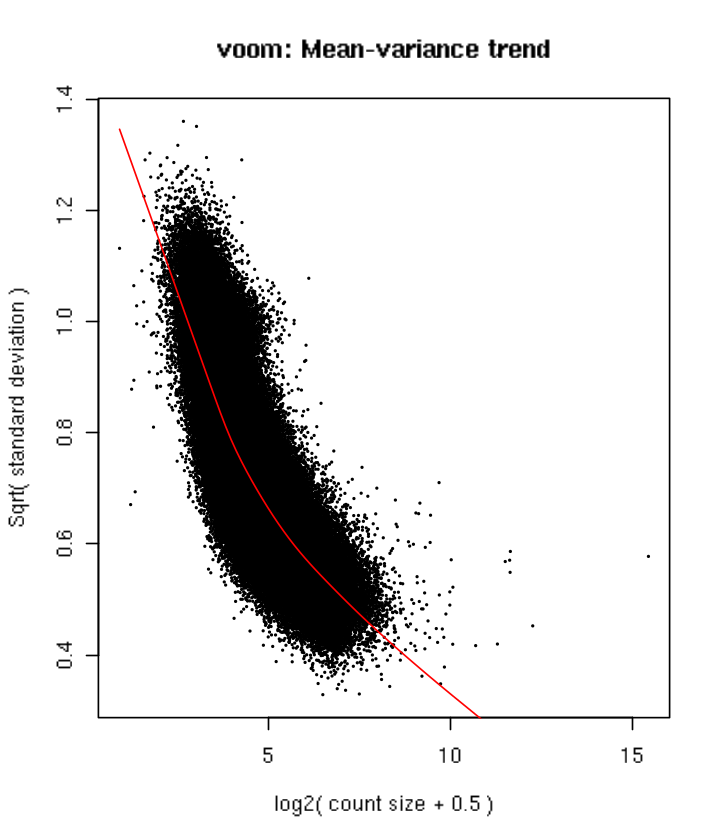

In [88]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [89]:
pca <- prcomp(t(as.matrix(y)))

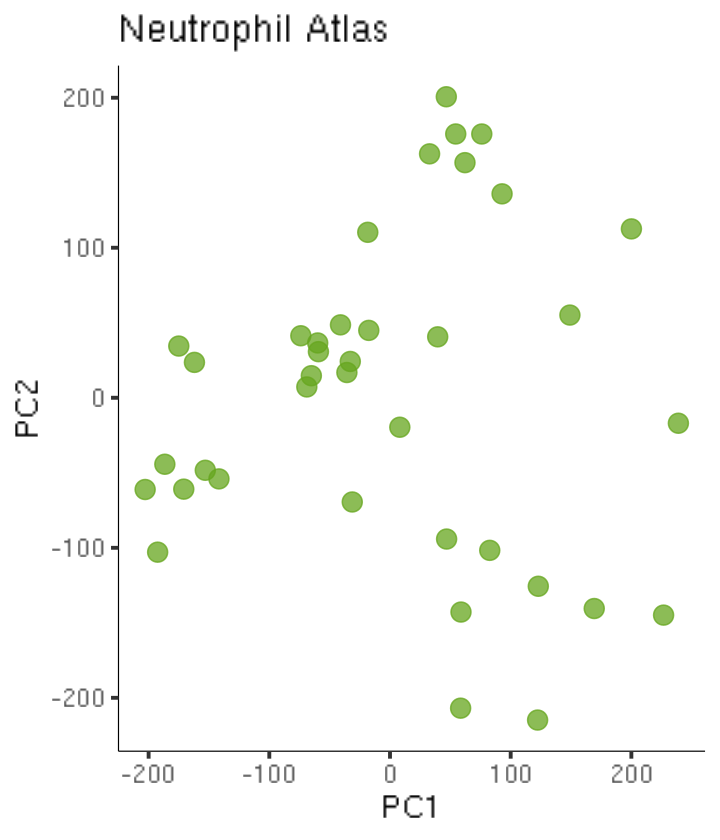

In [90]:
options(repr.plot.width=6, repr.plot.height=7)

merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2), size=I(5), alpha=0.75, color=brewer.pal("Dark2", n=5)[5]) +
    ggtitle("Neutrophil Atlas") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/neutrophil_normalized_peak_count_pca.svg", width=6, height=7)

In [91]:
umap.res <- umap(scale(t(as.matrix(y))))

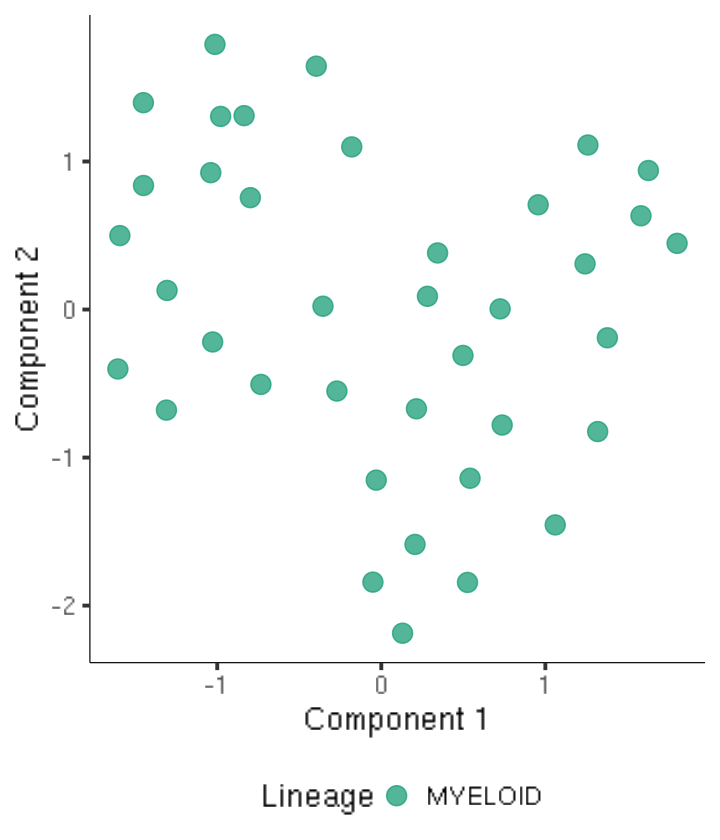

In [92]:
options(repr.plot.width=6, repr.plot.height=7)

umap.res$layout %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Group.ID=rownames(.)) %>%
    merge(., sample.info, by="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

### Limma Fit

Use `limma` to fit a linear model consisting of the biological `groups`.

In [93]:
fit <- lmFit(y, design)

### Limma DA Peaks

Create the contrast matrix. There are three sets of contrasts:

1. Neutrophil DAMP/PAMP Stimulation vs. Control
    1. LTA vs. Control (TLR2)
    2. LPS vs. Control (TLR4)
    3. FLAG vs. Control (TLR5)
    4. R848 vs. Control (TLR7/TLR8)
    5. BGP vs. Control (Dectin-1)
    6. HMGB1 vs. Control (TLR4)
2. Whole-Organism *S. aureus* in Whole Blood vs. Untreated Whole Blood
    1. $10^1$ Cells of *S. aureus* in Whole Blood vs. Untreated Whole Blood
    2. $10^3$ Cells of *S. aureus* in Whole Blood vs. Untreated Whole Blood
    3. $10^5$ Cells of *S. aureus* in Whole Blood vs. Untreated Whole Blood
3. Whole-Organism *E. coli* in Whole Blood vs. Untreated Whole Blood
    1. *E. coli* for 1 hour in Whole Blood vs. Untreated Whole Blood for 1 hour
    2. *E. coli* for 4 hours in Whole Blood vs. Untreated Whole Blood for 4 hours

In [98]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=11)
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- c(
    "LTA-Control", "LPS-Control", "FLAG-Control", "R848-Control", "BGP-Control", "HMGB1-Control",
    "SA1-WB", "SA3-WB", "SA5-WB",
    "EC1h-noEC1h", "EC4h-noEC4h"
)

for (contrast.id in colnames(contrast)) {
    contrast[paste0("stimulated", gsub("-.*$", "", contrast.id)), contrast.id] = 1
    contrast[paste0("stimulated", gsub("^.*-", "", contrast.id)), contrast.id] = -1
}

In [101]:
da.peaks <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)

    treatment = gsub("-.*$", "", colnames(contrast)[i])

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Treatment=treatment) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Treatment, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

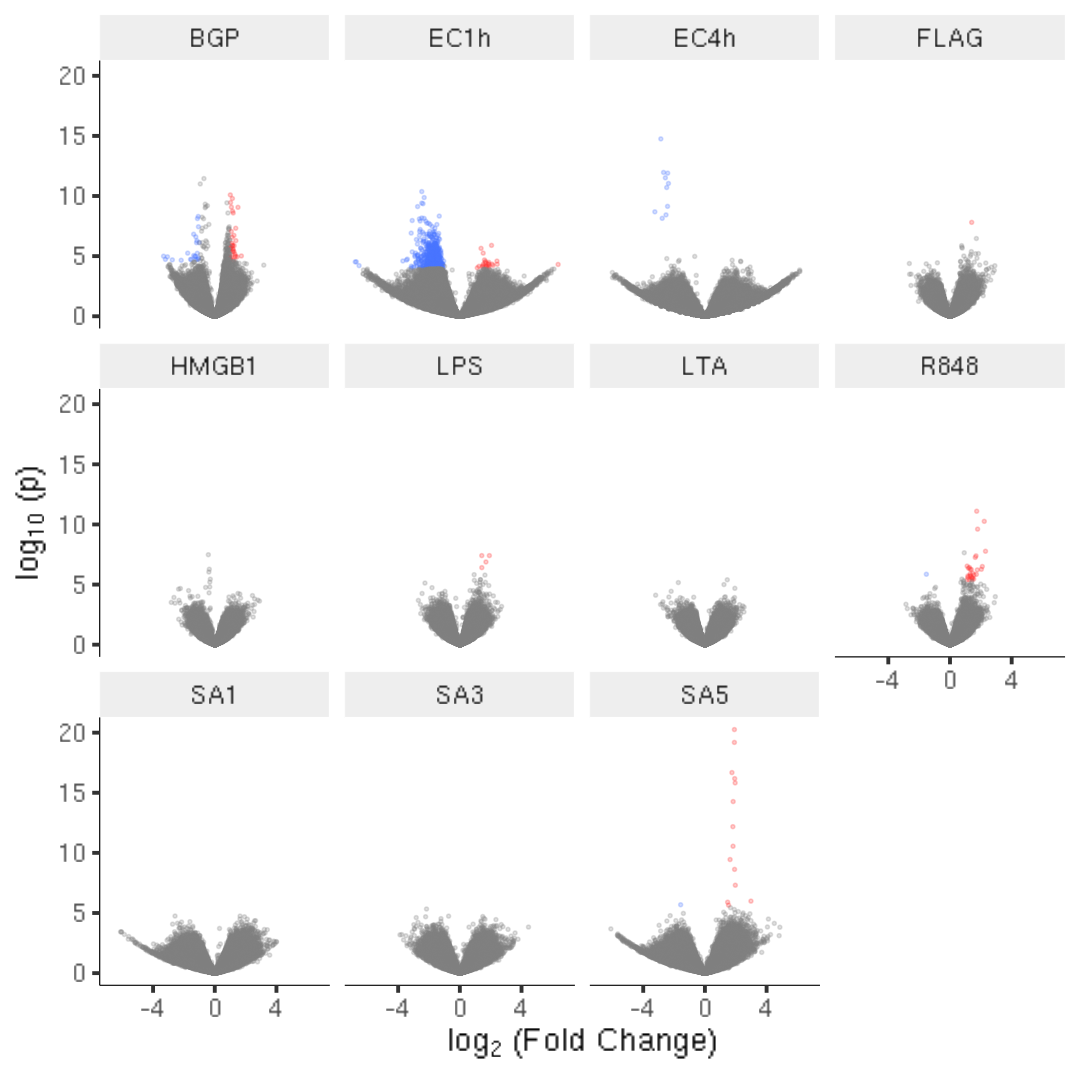

In [104]:
options(repr.plot.width=9, repr.plot.height=9)

abs.max.log.fc <- max(abs(da.peaks$logFC))

da.peaks %>%
    dplyr::mutate(log.P.Val=-log10(P.Value)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.05 & logFC > 1, "More", ifelse(adj.P.Val < 0.05 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Treatment)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/neutrophil_da_peaks_volcano_plots.png", width=9, height=9)

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.05 and the absolute log fold change is greater than 1.

In [123]:
da.peak.set <- da.peaks %>%
    dplyr::filter(adj.P.Val < 0.05) %>%
    dplyr::filter(abs(logFC) > 1)

write.csv(da.peak.set, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/da_peak_set.csv")

There are 844 peaks that are DA peaks in at least one treatment for neutrophils.

In [124]:
length(unique(da.peak.set$Peak.ID))

[1] 844

In [125]:
table(da.peak.set$Contrast)


 BGP-Control  EC1h-noEC1h  EC4h-noEC4h FLAG-Control  LPS-Control R848-Control 
          57          754           10            1            4           30 
      SA5-WB 
          15 